<a href="https://colab.research.google.com/github/taba4ek555/Diplom/blob/main/Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Добавляем гугл диск в гугл колаб с готовым датасетом
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Распаковываем архив с датасетом
!unzip /content/drive/MyDrive/LFW-FER.zip -d ./


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./LFW-FER/train/neutral/Nanni_Moretti_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Nanni_Moretti_0002.jpg  
  inflating: ./LFW-FER/train/neutral/Hushiar_Zebari_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Hushiar_Zebari_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Allen_Rock_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Allen_Rock_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Keith_Bogans_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Keith_Bogans_0002.jpg  
  inflating: ./LFW-FER/train/neutral/John_Kerry_0017.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._John_Kerry_0017.jpg  
  inflating: ./LFW-FER/train/neutral/Maria_Soledad_Alvear_Valenzuela_0001.jpg  
  inflating: ./__MACOSX/LFW-FER/train/neutral/._Maria_Soledad_Alvear_Valenzuela_0001.jpg  
  inflating: ./LFW-FER/train/neutral/Eric_Rosser_0002.jpg  
  inflating: ./__MACOSX/LFW-FER/train/

In [ ]:
#Импортирование библиотек
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import metrics
import cv2
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
#Создаём словари для кодирования эмоций и списки для хранения данных
numbers_names = {0: 'negative', 1: 'neutral', 2: 'positive'}
names_numbers = {'negative': 0, 'neutral': 1, 'positive': 2}
train_images = []
train_labels = []
test_images = []
test_labels = []

Загрузка изображений


In [ ]:
folders = [folder for folder in os.listdir('./LFW-FER/train')if folder[0] != '.']
for i in range(len(folders)):
    folder = folders[i]
    for image_path in os.listdir(f'./LFW-FER/train/{folder}'):
        image = Image.open(f'./LFW-FER/train/{folder}/{image_path}')
        train_images.append(np.array(image))
        train_labels.append(names_numbers[folder])
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
folders = [folder for folder in os.listdir('./LFW-FER/eval')if folder[0] != '.']
for i in range(len(folders)):
    folder = folders[i]
    for image_path in os.listdir(f'./LFW-FER/eval/{folder}'):
        image = Image.open(f'./LFW-FER/eval/{folder}/{image_path}')
        test_images.append(np.array(image))
        test_labels.append(names_numbers[folder])
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
len(train_images), len(test_images)

(9330, 1157)

Пример изображений


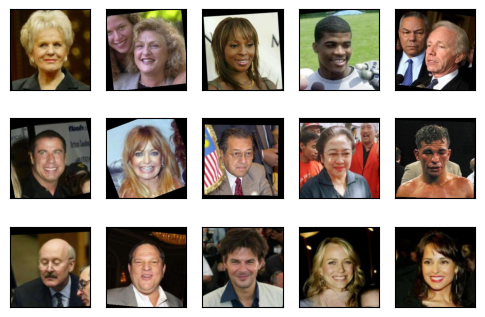

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(6, 4))
for i in range(15):
    ax = axs[i // 5, i % 5]
    ax.imshow(train_images[random.randint(0, len(train_images))])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1, 2]), array([ 768, 3359, 5203]))

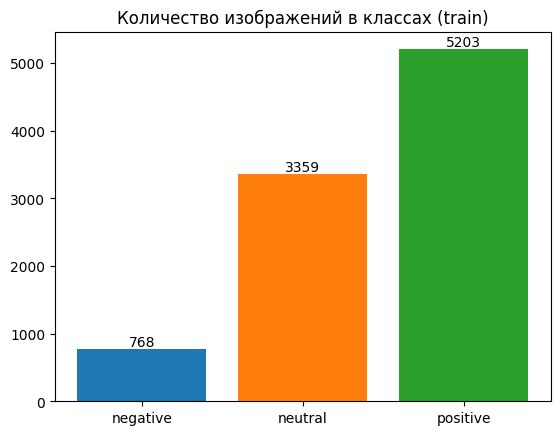

In [ ]:
for idx, label in enumerate(unique):
    bar = plt.bar(numbers_names[label], counts[idx], label=counts[idx])
    plt.bar_label(bar)
plt.title('Количество изображений в классах (train)')
plt.show()

In [ ]:
unique, counts = np.unique(test_labels, return_counts=True)
unique, counts

(array([0, 1, 2]), array([ 95, 417, 645]))

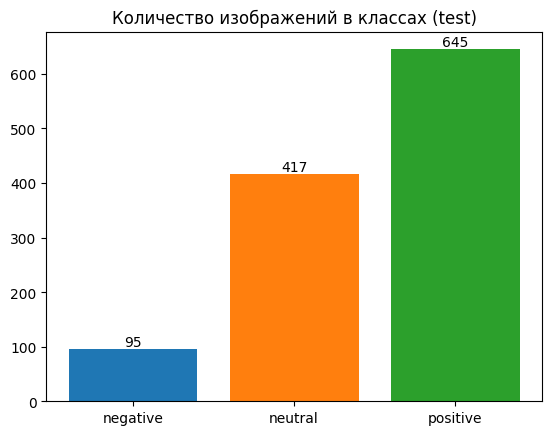

In [ ]:
for idx, label in enumerate(unique):
    bar = plt.bar(numbers_names[label], counts[idx], label=counts[idx])
    plt.bar_label(bar)
plt.title('Количество изображений в классах (test)')
plt.show()

Так как в наборе существует дисбаланс классов, необходимо использовать веса, чтобы модель больше уделяла внимания тем классам, в которых мало объектов

In [ ]:
#Используем веса для классов в котором мало объектов
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(train_labels),
                                    y=train_labels)
class_weight = dict(enumerate(class_weight))
class_weight

{0: 4.049479166666667, 1: 0.9258707948794284, 2: 0.597732077647511}

МОДЕЛИРОВАНИЕ


Для первой модели будем использовать 3 сверточных слоя с увеличением количества фильтров в два раза на каждом слое, также между ними будем использовать batch normalization слои для более быстрого обучения и слои max pooling для уменьшения изображения


In [ ]:
model1 = keras.Sequential([
    keras.Input(train_images[0].shape),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax'),
])

Воспользуемся чекпоинт коллбэком, чтобы во время обучения сохранить модель с наименьшей ошибкой


In [ ]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './model1.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

В качестве оптимизатора будет использоваться Nadam

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

#Обучение модели


In [ ]:
history = model1.fit(train_images, train_labels, epochs=20,
          callbacks=[checkpoint_callback],
          validation_data=[test_images, test_labels],
          batch_size=32, class_weight=class_weight, verbose=1)

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3443 - loss: 2.1506
Epoch 1: val_loss improved from inf to 1.27366, saving model to ./model1.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - accuracy: 0.3444 - loss: 2.1480 - val_accuracy: 0.4088 - val_loss: 1.2737
Epoch 2/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3846 - loss: 1.0885
Epoch 2: val_loss improved from 1.27366 to 1.21745, saving model to ./model1.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.3849 - loss: 1.0887 - val_accuracy: 0.5566 - val_loss: 1.2175
Epoch 3/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5177 - loss: 1.0842
Epoch 3: val_loss improved from 1.21745 to 0.99969, saving model to ./model1.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.5179 - loss: 1.0840 - val_accuracy: 0.6551 - val_loss: 0.9997
Epoch 4/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5943 - loss: 0.9855
Epoch 4: val_loss did not improve from 0.99969
292

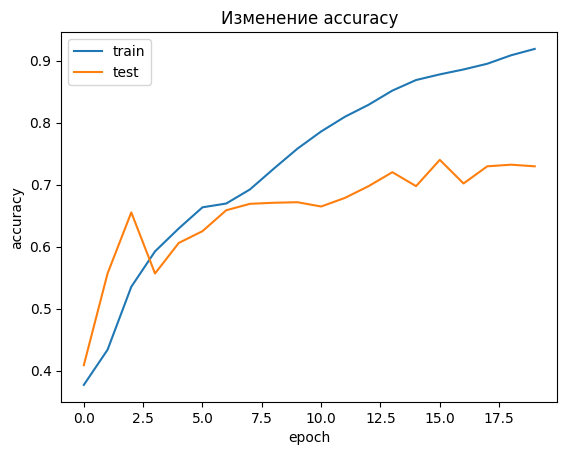

In [ ]:
#Выводим график точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Изменение accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

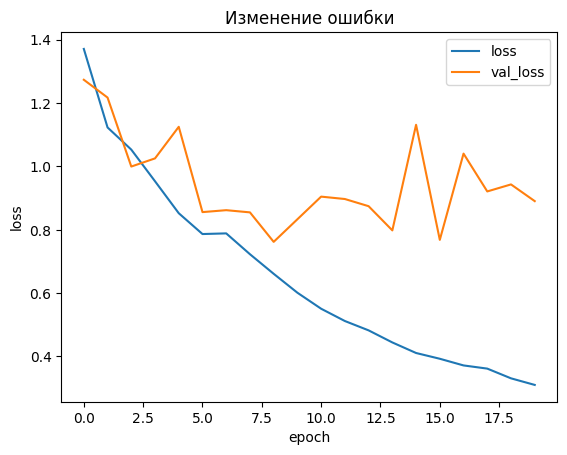

In [ ]:
#Визуализируем потери
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Изменение ошибки')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Модель сильно переобучилась, введем dropout слои, чтобы предотвратить сильное переобучение

In [ ]:
model2 = keras.Sequential([
    keras.Input(train_images[0].shape),
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(3, activation='softmax'),
])

In [ ]:
#Создаём чекпоинт
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './model2.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)

In [ ]:
#Добавляем оптимизатор
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

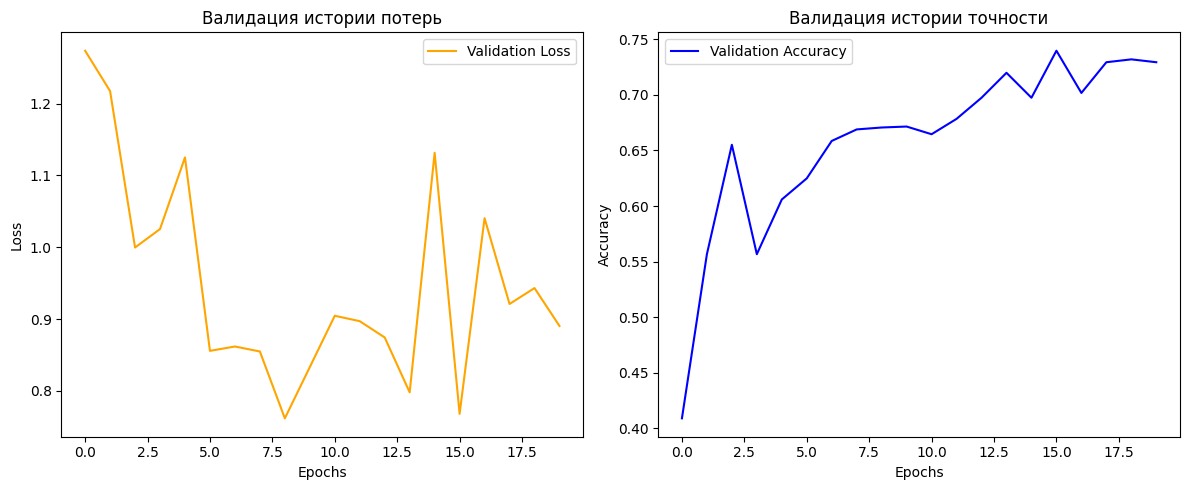

In [ ]:
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Валидация истории потерь')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Валидация истории точности')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Показать графики
plt.tight_layout()
plt.show()

In [ ]:
history = model2.fit(train_images, train_labels, epochs=20,
          callbacks=[checkpoint_callback],
          validation_data=[test_images, test_labels],
          batch_size=32, class_weight=class_weight, verbose=1)

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1953 - loss: 2.4821
Epoch 1: val_loss improved from inf to 1.30168, saving model to ./model2.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accuracy: 0.1951 - loss: 2.4785 - val_accuracy: 0.2411 - val_loss: 1.3017
Epoch 2/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1098 - loss: 1.1052
Epoch 2: val_loss improved from 1.30168 to 1.11757, saving model to ./model2.keras
292/292 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.1098 - loss: 1.1052 - val_accuracy: 0.3129 - val_loss: 1.1176
Epoch 3/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1991 - loss: 1.0988
Epoch 3: val_loss did not improve from 1.11757
292/292 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.1992 - loss: 1.0988 - val_accuracy: 0.1945 - val_loss: 1.1747
Epoch 4/20
291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2365 - loss: 1.0929
Epoch 4: val_loss did not improve from 1.11757
292/292 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/s

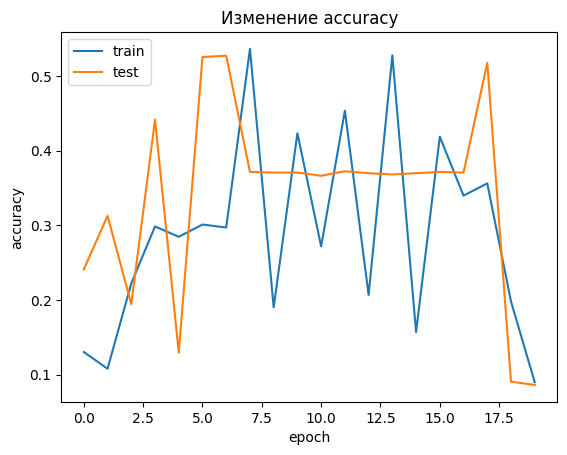

In [ ]:
#Смотрим изменение точности
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Изменение accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

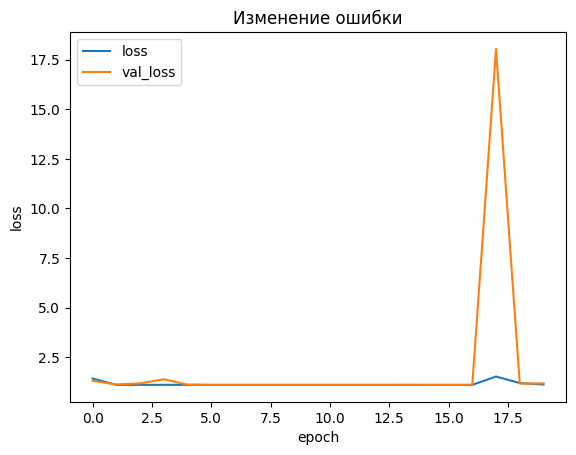

In [ ]:
#Смотрим изменение ошибки
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Изменение ошибки')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

Модель оказалась слишком слабой и недообученной, попробуем другую архитектуру, между слоев max pooling будет по два сверточных слоя, между которыми будет batch normalization, количество фильтров не будет меняться, dropout будем использовать только между двух полносвязных слоев

In [ ]:
model3 = keras.Sequential([
    keras.Input(train_images[0].shape),
    keras.layers.Conv2D(20, (4, 4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (3, 3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(20, (4, 4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(20, (4, 4), activation='relu'),
    # keras.layers.MaxPool2D(),
    # keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Conv2D(24, (3, 3), activation='relu'),
    # keras.layers.MaxPool2D(strides=2),
    # keras.layers.Conv2D(32, (3, 3), activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Conv2D(12, (3, 3), activation='relu'),
    keras.layers.MaxPool2D((4, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax'),
])

In [ ]:
#Структура модели
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 247, 247, 20)        │             980 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 247, 247, 20)        │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 245, 245, 20)        │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 122, 122, 20)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 120, 120, 20)        │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 120, 120, 20)        │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 118, 118, 20)        │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 59, 59, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 57, 57, 20)          │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 57, 57, 20)          │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 55, 55, 20)          │           3,620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 27, 27, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 20)          │           6,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 24, 24, 20)          │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 21, 21, 20)          │           6,420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 5, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 96)                  │          48,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 80,627 (314.95 KB)

 Trainable params: 80,467 (314.32 KB)

 Non-trainable params: 160 (640.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

In [ ]:
#Сохраняем модель во время обучения на гугл диск
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './drive/MyDrive/model3_1.keras',
    save_weights_only=False,
    save_best_only=True,
    save_freq="epoch",
    verbose=1
)


Также удвоим значение веса для самого минорного класса - лиц с негативным выражением

In [ ]:
model3_class_weight = class_weight.copy()
model3_class_weight[0] *= 2
history = model3.fit(train_images, train_labels, epochs=40, #70
          callbacks=[checkpoint_callback],
          validation_data=[test_images, test_labels],
          batch_size=128, class_weight=model3_class_weight, verbose=1)

Epoch 1/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.2089 - loss: 1.7279
Epoch 1: val_loss improved from inf to 1.15099, saving model to ./drive/MyDrive/model3_1.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 86s 756ms/step - accuracy: 0.2084 - loss: 1.7252 - val_accuracy: 0.0821 - val_loss: 1.1510
Epoch 2/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.0937 - loss: 1.3871
Epoch 2: val_loss improved from 1.15099 to 1.11906, saving model to ./drive/MyDrive/model3_1.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 23s 280ms/step - accuracy: 0.0936 - loss: 1.3869 - val_accuracy: 0.1141 - val_loss: 1.1191
Epoch 3/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.1239 - loss: 1.3468
Epoch 3: val_loss did not improve from 1.11906
73/73 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - accuracy: 0.1241 - loss: 1.3465 - val_accuracy: 0.1469 - val_loss: 1.1398
Epoch 4/40
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.2148 - loss: 1.2682
Epoch 4: val_loss improved from 1.11906 to 1.07691, saving mo

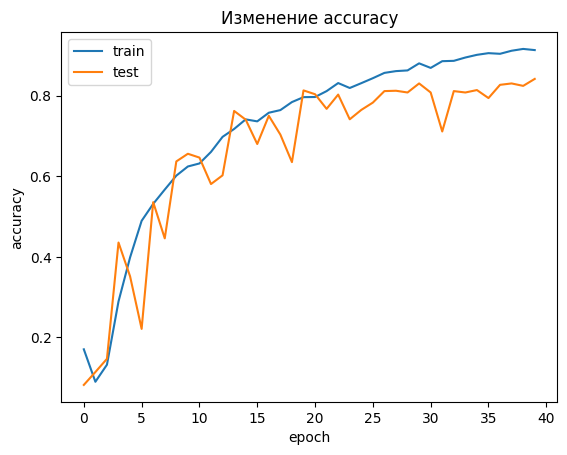

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Изменение accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

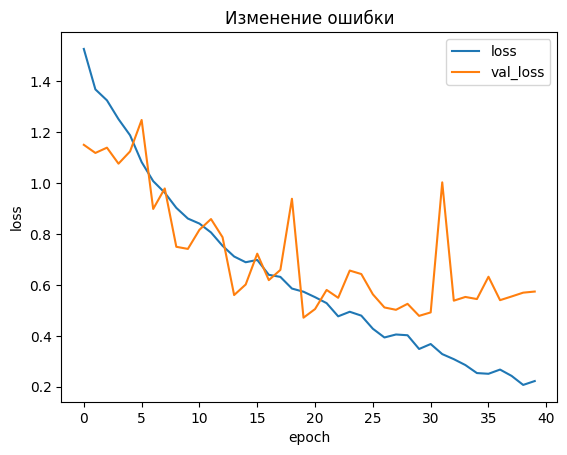

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Изменение ошибки')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()